In [105]:
import numpy as np
import torch 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
palette = plt.rcParams['axes.prop_cycle'].by_key()['color']
import seaborn as sns
import robust_loss_pytorch.general
import numpy.random as npr
from robust_loss_pytorch import distribution
from sklearn.preprocessing import scale as scaler
import random
import torch.nn as nn
# Construct some regression data with some extreme outliers.
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
np.random.seed(1234)

class RegressionModel(torch.nn.Module): 
    # A simple linear regression module.
    def __init__(self): 
        super(RegressionModel, self).__init__() 
        self.linear = torch.nn.Linear(1, 1)
    def forward(self, x): 
        return self.linear(x[:,None])[:,0]
    
class Poly2RegressionModel(torch.nn.Module): 
    # A simple linear regression module.
    def __init__(self): 
        super(Poly2RegressionModel, self).__init__() 
        self.linear = torch.nn.Linear(2, 1)
    def forward(self, x): 
        x = torch.cat([(x**2).view(-1,1), x.view(-1,1)], axis=1)
        return self.linear(x)[:,0]
    
class Poly2RegressionModel_with_class(torch.nn.Module): 
    # A simple linear regression module.
    def __init__(self): 
        super(Poly2RegressionModel_with_class, self).__init__() 
        self.linear = torch.nn.Linear(3, 1)
    def forward(self, x, c): 
        x = torch.cat([(x**2).view(-1,1), x.view(-1,1)], axis=1)
        x = torch.cat([x, c.view(-1,1)], axis=1)
        return self.linear(x)[:,0]

def plot_regression(regression, u=None, c=None):
    # A helper function for plotting a regression module.
    x_plot = np.linspace(min(x), max(x), 500)
    if c is None:
        y_plot = regression(torch.Tensor(x_plot)).detach().numpy()
    else:
        y_plot = regression(torch.Tensor(x_plot), c).detach().numpy()
#     y_plot_true = x_plot * scale_true + shift_true
    
    plt.figure(0, figsize=(4,4))
    if u is not None:
        sns.scatterplot(x, y, hue=U)
    else:
        sns.scatterplot(x, y)
#     plt.plot(x_plot, y_plot_true, color='k')
    plt.plot(x_plot, y_plot, color='navy', label='regressor')
    plt.legend()

In [106]:
def generate_delta_noise(n:int, x_range:list, delta=10, rate=0.01, beta1=3, beta0=0, scale=1, hetero=False):
    X = npr.uniform(x_range[0], x_range[1], n)
    X = np.array(sorted(X))
    scales = scale*np.ones(len(X))
    if hetero:
        scales[X>0]+=(X**2+5*X)[X>0]
    Y = npr.normal(beta1*X+beta0, scales)
    
    
    noise = np.array([False]*n)
    idx = np.random.choice(int(n/5), int(n*rate), replace=False)
    noise[idx]= True
    Y[noise] = npr.normal(beta1*(X[noise]+delta)+beta0)
    X = scaler(X)
    Y = scaler(Y)
    
    return X, Y, noise

# Heteroskedastic data

Text(0.5, 1.0, 'n = 1000')

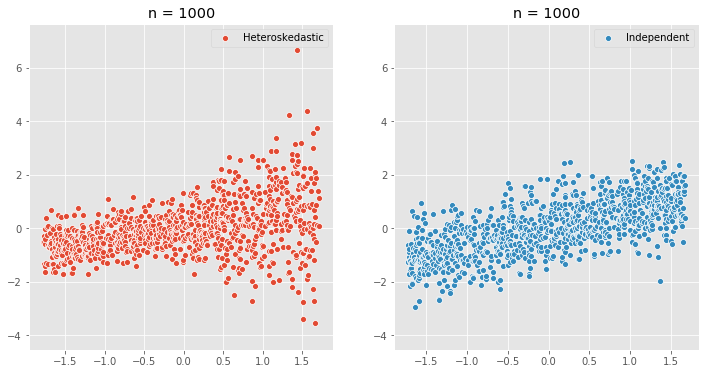

In [107]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

x_indep, y_indep, noise_indep = generate_delta_noise(1000, [-0.5, 0.5], delta=3, rate=0.00, hetero=False, beta0=0)
x_hetero, y_hetero, noise_hetero = generate_delta_noise(1000, [-0.5, 0.5], delta=3, rate=0.00, hetero=True, beta0=0)
ax[0].set_ylim([min(y_hetero)-1, max(y_hetero)+1])
sns.scatterplot(x_hetero, y_hetero, label='Heteroskedastic', color=palette[0], ax=ax[0])
ax[1].set_ylim([min(y_hetero)-1, max(y_hetero)+1])
sns.scatterplot(x_indep, y_indep, label='Independent', color=palette[1], ax=ax[1])
ax[0].set_title('n = 1000')
ax[1].set_title('n = 1000')
# plt.savefig('synthetic_data_noise.png')

# Density data

Text(0.5, 1.0, 'n = 250')

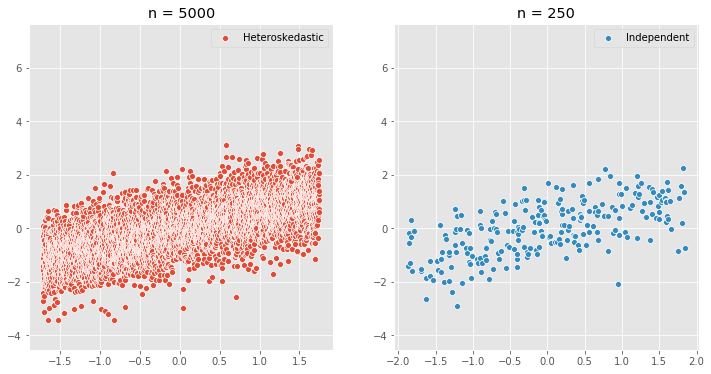

In [108]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

x_dense, y_dense, noise_dense = generate_delta_noise(5000, [-0.5, 0.5], delta=3, rate=0.00, hetero=False, beta0=0)
x_sparse, y_sparse, noise_sparse = generate_delta_noise(250, [-0.5, 0.5], delta=3, rate=0.00, hetero=False, beta0=0)
ax[0].set_ylim([min(y_hetero)-1, max(y_hetero)+1])
sns.scatterplot(x_dense, y_dense, label='Heteroskedastic', color=palette[0], ax=ax[0])
ax[1].set_ylim([min(y_hetero)-1, max(y_hetero)+1])
sns.scatterplot(x_sparse, y_sparse, label='Independent', color=palette[1], ax=ax[1])
ax[0].set_title('n = 5000')
ax[1].set_title('n = 250')
# plt.savefig('synthetic_data_sparse.png')

## Linear regression with regular MSE

0   : loss=99.594589
500 : loss=42.044056
1000: loss=42.044056
1500: loss=42.044056
MSE: 0.840881


OrderedDict([('weight', Parameter containing:
              tensor([[0.3989]], requires_grad=True)),
             ('bias', Parameter containing:
              tensor([-3.2406e-09], requires_grad=True))])

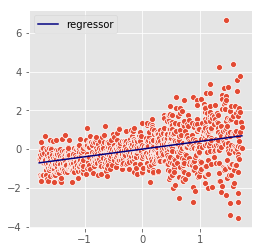

In [109]:
# Fit a linear regression using mean squared error.
regression = RegressionModel() 
params = regression.parameters()
optimizer = torch.optim.Adam(list(params), lr = 0.01) 
x = torch.Tensor(x_hetero)
y = torch.Tensor(y_hetero)
for epoch in range(2000): 

    y_i = regression(x) 
    
    # Hijacking the general loss to compute MSE.
    loss = torch.mean(robust_loss_pytorch.general.lossfun(
        y_i - y, alpha=torch.Tensor([2.]), scale=torch.Tensor([0.1])))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 500) == 0:
        print('{:<4}: loss={:03f}'.format(epoch, loss.data)) 
plot_regression(regression)
regression.linear._parameters
y_hat = regression(x) 
mse = ((y_hat-y)**2).mean().detach().numpy()
print('MSE: {:02f}'.format(mse))
regression.linear._parameters

0   : loss=51.018623
500 : loss=27.251501
1000: loss=27.251501
1500: loss=27.251501
MSE: 0.545030


OrderedDict([('weight', Parameter containing:
              tensor([[0.6745]], requires_grad=True)),
             ('bias', Parameter containing:
              tensor([1.1249e-08], requires_grad=True))])

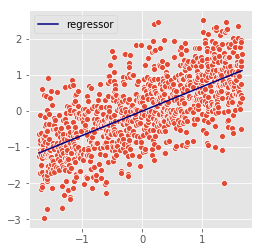

In [110]:
# Fit a linear regression using mean squared error.
regression = RegressionModel() 
params = regression.parameters()
optimizer = torch.optim.Adam(params, lr = 0.01) 
x = torch.Tensor(x_indep)
y = torch.Tensor(y_indep)
for epoch in range(2000): 

    y_i = regression(x) 
    
    # Hijacking the general loss to compute MSE.
    loss = torch.mean(robust_loss_pytorch.general.lossfun(
        y_i - y, alpha=torch.Tensor([2.]), scale=torch.Tensor([0.1])))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 500) == 0:
        print('{:<4}: loss={:03f}'.format(epoch, loss.data)) 
plot_regression(regression)
regression.linear._parameters
y_hat = regression(x) 
mse = ((y_hat-y)**2).mean().detach().numpy()
print('MSE: {:02f}'.format(mse))
regression.linear._parameters

## Linear regression with Adaptive Roust loss

0   : loss=1.555003  alpha=1.997990  scale=1.006333
500 : loss=1.266236  alpha=0.746021  scale=0.478400
1000: loss=1.266215  alpha=0.729441  scale=0.474370
1500: loss=1.266215  alpha=0.729441  scale=0.474370
2000: loss=1.266215  alpha=0.729441  scale=0.474370
2500: loss=1.266215  alpha=0.729440  scale=0.474369
3000: loss=1.266215  alpha=0.729441  scale=0.474370
3500: loss=1.266215  alpha=0.729441  scale=0.474369
MSE: 0.841115


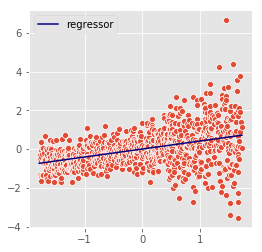

In [111]:
# Fit a linear regression, and the parameters of an adaptive loss.
regression = RegressionModel() 
adaptive = robust_loss_pytorch.adaptive.AdaptiveLossFunction(
    num_dims = 1, float_dtype=np.float32, device='cpu', alpha_init=1.998)
params = list(regression.parameters()) + list(adaptive.parameters())
optimizer = torch.optim.Adam(params, lr = 0.01) 
x = torch.Tensor(x_hetero)
y = torch.Tensor(y_hetero)
hetero_alpha = []
hetero_scale = []
for epoch in range(4000): 

    y_i = regression(x) 
    
    # Stealthily unsqueeze to an (n,1) matrix, and then compute the loss.
    # A matrix with this shape corresponds to a loss where there's one shape+scale parameter
    # per dimension (and there's only one dimension for this data).
    loss = torch.mean(adaptive.lossfun((y_i - y)[:,None]))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 500) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}  alpha={:03f}  scale={:03f}'.format(
            epoch, loss.data, adaptive.alpha()[0,0].data, adaptive.scale()[0,0].data)) 
    hetero_alpha.append(adaptive.alpha()[0,0].data.numpy())
    hetero_scale.append(adaptive.scale()[0,0].data.numpy())

# It fits!
plot_regression(regression)
regression.linear._parameters
y_hat = regression(x) 
mse = ((y_hat-y)**2).mean().detach().numpy()
print('MSE: {:02f}'.format(mse))

0   : loss=1.657836  alpha=1.997990  scale=1.006333
500 : loss=1.115471  alpha=1.998264  scale=0.735986
1000: loss=1.115469  alpha=1.997989  scale=0.735682
1500: loss=1.115462  alpha=1.996732  scale=0.734370
2000: loss=1.115107  alpha=1.870951  scale=0.668911
2500: loss=1.115107  alpha=1.870853  scale=0.668922
3000: loss=1.115107  alpha=1.870853  scale=0.668922
3500: loss=1.115107  alpha=1.870897  scale=0.668930


OrderedDict([('weight', Parameter containing:
              tensor([[0.6760]], requires_grad=True)),
             ('bias', Parameter containing:
              tensor([-0.0026], requires_grad=True))])

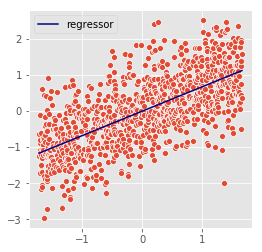

In [112]:
# Fit a linear regression, and the parameters of an adaptive loss.
regression = RegressionModel() 
adaptive = robust_loss_pytorch.adaptive.AdaptiveLossFunction(
    num_dims = 1, float_dtype=np.float32, device='cpu', alpha_init=1.998)
params = list(regression.parameters()) + list(adaptive.parameters())
optimizer = torch.optim.Adam(params, lr = 0.01) 
x = torch.Tensor(x_indep)
y = torch.Tensor(y_indep)
indep_alpha = []
indep_scale = []
for epoch in range(4000): 

    y_i = regression(x) 
    
    # Stealthily unsqueeze to an (n,1) matrix, and then compute the loss.
    # A matrix with this shape corresponds to a loss where there's one shape+scale parameter
    # per dimension (and there's only one dimension for this data).
    loss = torch.mean(adaptive.lossfun((y_i - y)[:,None]))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 500) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}  alpha={:03f}  scale={:03f}'.format(
            epoch, loss.data, adaptive.alpha()[0,0].data, adaptive.scale()[0,0].data)) 
    indep_alpha.append(adaptive.alpha()[0,0].data.numpy())
    indep_scale.append(adaptive.scale()[0,0].data.numpy())

# It fits!
plot_regression(regression)
regression.linear._parameters

Text(0, 0.5, 'log alpha')

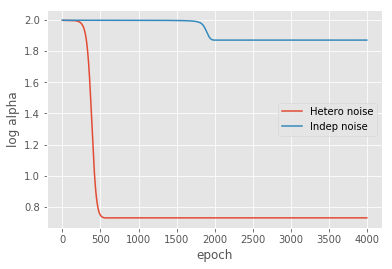

In [113]:
sns.lineplot(np.arange(len(hetero_alpha)), np.array(hetero_alpha), label="Hetero noise")
sns.lineplot(np.arange(len(hetero_alpha)), np.array(indep_alpha), label="Indep noise")
plt.xlabel('epoch')
plt.ylabel('log alpha')
# plt.savefig('alpha_convergence_noise.png')

Text(0, 0.5, 'log scale parameter')

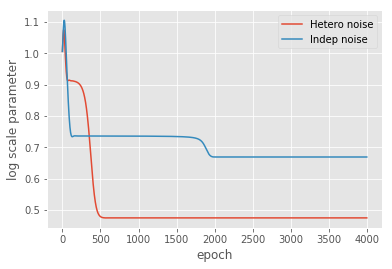

In [114]:
sns.lineplot(np.arange(len(hetero_alpha)), np.array(hetero_scale), label="Hetero noise")
sns.lineplot(np.arange(len(hetero_alpha)), np.array(indep_scale), label="Indep noise")
plt.xlabel('epoch')
plt.ylabel('log scale parameter')
# plt.savefig('scale_convergence_noise.png')

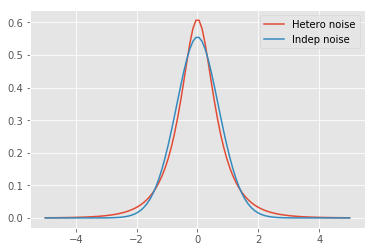

In [115]:
dist = distribution.Distribution()
alpha=hetero_alpha[-1]
scale=hetero_scale[-1]
x_range = 5
y = dist.nllfun(torch.Tensor(np.linspace(-x_range, x_range, 100)), float(alpha), float(scale)).data.numpy()
sns.lineplot(np.linspace(-x_range, x_range, 100), np.exp(-y), label='Hetero noise')

alpha=indep_alpha[-1] 
scale=indep_scale[-1]
y = dist.nllfun(torch.Tensor(np.linspace(-x_range, x_range, 100)), float(alpha), float(scale)).data.numpy()
sns.lineplot(np.linspace(-x_range, x_range, 100), np.exp(-y), label='Indep noise')
# plt.savefig('learned_kernel_noise.png')

0   : loss=1.209930  alpha=1.998010  scale=0.993690
500 : loss=1.140896  alpha=1.998365  scale=0.755053
1000: loss=1.140896  alpha=1.998429  scale=0.755129
1500: loss=1.140896  alpha=1.998505  scale=0.755217
2000: loss=1.140895  alpha=1.998587  scale=0.755315
2500: loss=1.140896  alpha=1.998666  scale=0.755410
3000: loss=1.140895  alpha=1.998735  scale=0.755492
3500: loss=1.140895  alpha=1.998782  scale=0.755549
4000: loss=1.140895  alpha=1.998825  scale=0.755602
4500: loss=1.140895  alpha=1.998864  scale=0.755649
MSE: 0.573445


OrderedDict([('weight', Parameter containing:
              tensor([[0.6529]], requires_grad=True)),
             ('bias', Parameter containing:
              tensor([0.0007], requires_grad=True))])

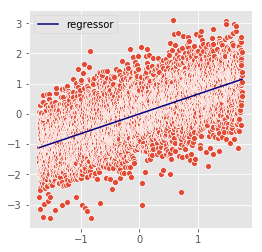

In [116]:
# Fit a linear regression, and the parameters of an adaptive loss.
regression = RegressionModel() 
adaptive = robust_loss_pytorch.adaptive.AdaptiveLossFunction(
    num_dims = 1, float_dtype=np.float32, device='cpu', alpha_init=1.998)
params = list(regression.parameters()) + list(adaptive.parameters())
optimizer = torch.optim.Adam(params, lr = 0.01) 
x = torch.Tensor(x_dense)
y = torch.Tensor(y_dense)
dense_alpha = []
dense_scale = []
for epoch in range(5000): 

    y_i = regression(x) 
    
    # Stealthily unsqueeze to an (n,1) matrix, and then compute the loss.
    # A matrix with this shape corresponds to a loss where there's one shape+scale parameter
    # per dimension (and there's only one dimension for this data).
    loss = torch.mean(adaptive.lossfun((y_i - y)[:,None]))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 500) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}  alpha={:03f}  scale={:03f}'.format(
            epoch, loss.data, adaptive.alpha()[0,0].data, adaptive.scale()[0,0].data)) 
    dense_alpha.append(adaptive.alpha()[0,0].data.numpy())
    dense_scale.append(adaptive.scale()[0,0].data.numpy())

# It fits!
plot_regression(regression)
regression.linear._parameters
y_hat = regression(x) 
mse = ((y_hat-y)**2).mean().detach().numpy()
print('MSE: {:02f}'.format(mse))
regression.linear._parameters

0   : loss=2.354136  alpha=1.997990  scale=1.006333
500 : loss=1.159400  alpha=1.998292  scale=0.769068
1000: loss=1.159399  alpha=1.998320  scale=0.769101
1500: loss=1.159399  alpha=1.998357  scale=0.769144
2000: loss=1.159400  alpha=1.998398  scale=0.769194
2500: loss=1.159399  alpha=1.998449  scale=0.769254
3000: loss=1.159399  alpha=1.998502  scale=0.769317
3500: loss=1.159399  alpha=1.998560  scale=0.769388
4000: loss=1.159399  alpha=1.998619  scale=0.769458
4500: loss=1.159398  alpha=1.998677  scale=0.769530
MSE: 0.595061


OrderedDict([('weight', Parameter containing:
              tensor([[0.6364]], requires_grad=True)),
             ('bias', Parameter containing:
              tensor([5.1136e-06], requires_grad=True))])

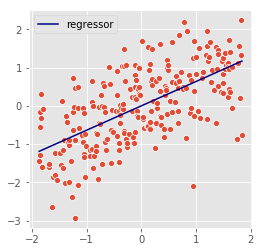

In [117]:
# Fit a linear regression, and the parameters of an adaptive loss.
regression = RegressionModel() 
adaptive = robust_loss_pytorch.adaptive.AdaptiveLossFunction(
    num_dims = 1, float_dtype=np.float32, device='cpu', alpha_init=1.998)
params = list(regression.parameters()) + list(adaptive.parameters())
optimizer = torch.optim.Adam(params, lr = 0.01) 
x = torch.Tensor(x_sparse)
y = torch.Tensor(y_sparse)
sparse_alpha = []
sparse_scale = []
for epoch in range(5000): 

    y_i = regression(x) 
    
    # Stealthily unsqueeze to an (n,1) matrix, and then compute the loss.
    # A matrix with this shape corresponds to a loss where there's one shape+scale parameter
    # per dimension (and there's only one dimension for this data).
    loss = torch.mean(adaptive.lossfun((y_i - y)[:,None]))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 500) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}  alpha={:03f}  scale={:03f}'.format(
            epoch, loss.data, adaptive.alpha()[0,0].data, adaptive.scale()[0,0].data)) 
    sparse_alpha.append(adaptive.alpha()[0,0].data.numpy())
    sparse_scale.append(adaptive.scale()[0,0].data.numpy())

# It fits!
plot_regression(regression)
regression.linear._parameters
y_hat = regression(x) 
mse = ((y_hat-y)**2).mean().detach().numpy()
print('MSE: {:02f}'.format(mse))
regression.linear._parameters

Text(0, 0.5, 'log alpha')

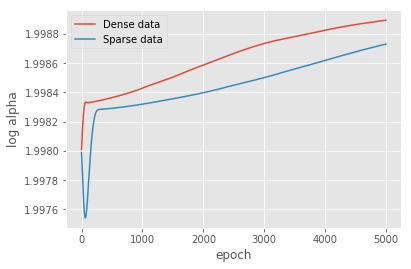

In [118]:
sns.lineplot(np.arange(len(dense_alpha)), np.array(dense_alpha), label="Dense data")
sns.lineplot(np.arange(len(dense_alpha)), np.array(sparse_alpha), label="Sparse data")
plt.xlabel('epoch')
plt.ylabel('log alpha')
# plt.savefig('alpha_convergence_sparse.png')

Text(0, 0.5, 'log scale parameter')

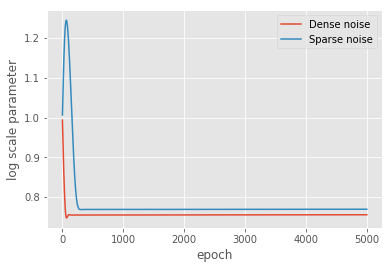

In [119]:
sns.lineplot(np.arange(len(dense_alpha)), np.array(dense_scale), label="Dense noise")
sns.lineplot(np.arange(len(dense_alpha)), np.array(sparse_scale), label="Sparse noise")
plt.xlabel('epoch')
plt.ylabel('log scale parameter')
# plt.savefig('scale_convergence_sparse.png')

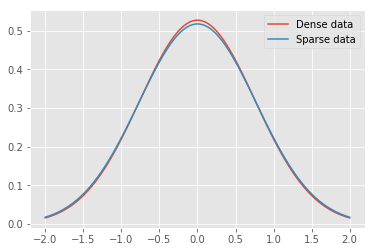

In [120]:
dist = distribution.Distribution()
alpha=dense_alpha[-1]
scale=dense_scale[-1]
x_range = 2
y = dist.nllfun(torch.Tensor(np.linspace(-x_range, x_range, 100)), float(alpha), float(scale)).data.numpy()
sns.lineplot(np.linspace(-x_range, x_range, 100), np.exp(-y), label='Dense data')

alpha=sparse_alpha[-1] 
scale=sparse_scale[-1]
y = dist.nllfun(torch.Tensor(np.linspace(-x_range, x_range, 100)), float(alpha), float(scale)).data.numpy()
sns.lineplot(np.linspace(-x_range, x_range, 100), np.exp(-y), label='Sparse data')
# plt.savefig('learned_kernel_sparse.png')

# Optimize Alpha for each data

In [121]:
# Fit a linear regression using mean squared error.
alpha_dense = nn.Parameter(torch.Tensor([0]*len(x_dense)))
scale_dense = nn.Parameter(torch.Tensor([0]*len(x_dense)))
optimizer = torch.optim.Adam([scale_dense, alpha_dense], lr = 1e-4) 
x = torch.Tensor(x_dense)
y = torch.Tensor(y_dense)
for epoch in range(20000): 
    
    # Hijacking the general loss to compute MSE.
    loss = torch.mean(robust_loss_pytorch.general.lossfun(
        y - x, alpha=torch.exp(alpha_dense), scale=torch.exp(scale_dense)))
    loss = loss + scale_dense.mean() + dist.log_base_partition_function(torch.exp(alpha_dense)).mean()
    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 1000) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}'.format(epoch, loss.data))  

0   : loss=1.449101
1000: loss=1.367850
2000: loss=1.290610
3000: loss=1.215532
4000: loss=1.140830
5000: loss=1.063094
6000: loss=0.955496
7000: loss=0.882130
8000: loss=0.833819
9000: loss=0.794812
10000: loss=0.761646
11000: loss=0.732747
12000: loss=0.707295
13000: loss=0.684746
14000: loss=0.664682
15000: loss=0.646784
16000: loss=0.630790
17000: loss=0.616465
18000: loss=0.603595
19000: loss=0.591996


In [122]:
alpha_hat_dense = torch.exp(alpha_dense).data.numpy()
scale_hat_dense = torch.exp(scale_dense).data.numpy()

Text(0.5, 0, 'X')

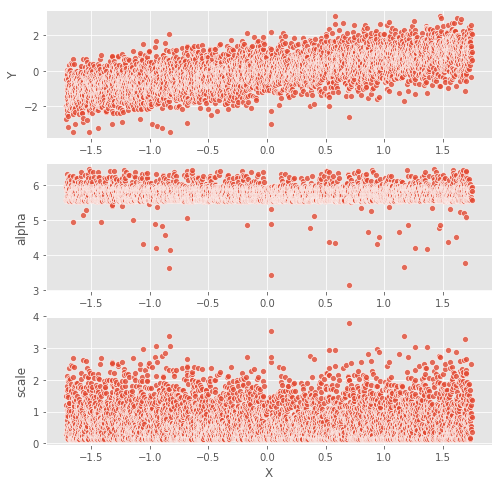

In [123]:
fig, ax = plt.subplots(3, 1, figsize=(8,8))
sns.scatterplot(x.data.numpy(), y.data.numpy(), ax=ax[0], alpha=0.8)
sns.scatterplot(x.data.numpy(), alpha_hat_dense, ax=ax[1], alpha=0.8)
sns.scatterplot(x.data.numpy(), scale_hat_dense, ax=ax[2], alpha=0.8)
ax[0].set_ylabel('Y')
ax[1].set_ylabel('alpha')
ax[2].set_ylabel('scale')
ax[2].set_xlabel('X')

In [124]:
# X_hat_dense = x.data.numpy()[alpha_hat_dense<2]
# noise_dense_hat = noise_dense[alpha_hat_dense<2]
# scale_hat_dense = scale_hat_dense[alpha_hat_dense<2]
# alpha_hat_dense = alpha_hat_dense[alpha_hat_dense<2]

In [125]:
# plt.figure(0, figsize=(4,4))
# sns.scatterplot(X_hat_dense, alpha_hat_dense)
# sns.scatterplot(X_hat_dense[noise_dense_hat], alpha_hat_dense[noise_dense_hat])

In [126]:
# Fit a linear regression using mean squared error.
alpha_sparse = nn.Parameter(torch.Tensor([0]*len(x_sparse)))
scale_sparse = nn.Parameter(torch.Tensor([0]*len(x_sparse)))
optimizer = torch.optim.Adam([scale_sparse, alpha_sparse], lr = 1e-4) 
x = torch.Tensor(x_sparse)
y = torch.Tensor(y_sparse)
for epoch in range(20000): 

    
    # Hijacking the general loss to compute MSE.
    loss = torch.mean(robust_loss_pytorch.general.lossfun(
        y - x, alpha=torch.exp(alpha_sparse), scale=torch.exp(scale_sparse)))
    loss = loss + scale_sparse.mean() + dist.log_base_partition_function(torch.exp(alpha_sparse)).mean()

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 1000) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}'.format(epoch, loss.data))  

0   : loss=1.455842
1000: loss=1.373819
2000: loss=1.295892
3000: loss=1.219960
4000: loss=1.144206
5000: loss=1.065228
6000: loss=0.955608
7000: loss=0.881701
8000: loss=0.833582
9000: loss=0.795267
10000: loss=0.763207
11000: loss=0.735900
12000: loss=0.712346
13000: loss=0.691635
14000: loss=0.673535
15000: loss=0.657552
16000: loss=0.643409
17000: loss=0.630795
18000: loss=0.619489
19000: loss=0.609308


Text(0.5, 0, 'X')

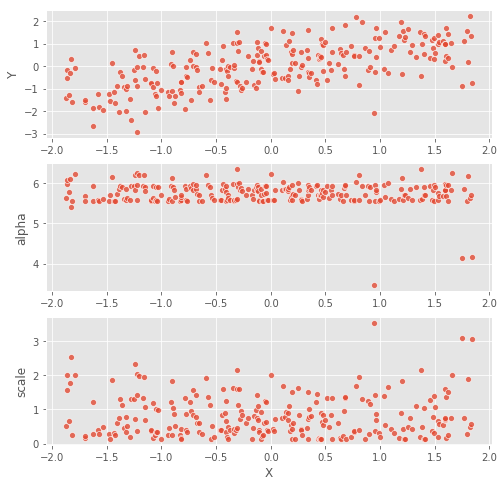

In [127]:
alpha_hat_sparse = torch.exp(alpha_sparse).data.numpy()
scale_hat_sparse = torch.exp(scale_sparse).data.numpy()
fig, ax = plt.subplots(3, 1, figsize=(8,8))
sns.scatterplot(x.data.numpy(), y.data.numpy(), ax=ax[0], alpha=0.8)
sns.scatterplot(x.data.numpy(), alpha_hat_sparse, ax=ax[1], alpha=0.8)
sns.scatterplot(x.data.numpy(), scale_hat_sparse, ax=ax[2], alpha=0.8)
ax[0].set_ylabel('Y')
ax[1].set_ylabel('alpha')
ax[2].set_ylabel('scale')
ax[2].set_xlabel('X')

In [128]:
# Fit a linear regression using mean squared error.
alpha_indep = nn.Parameter(torch.Tensor([0]*len(x_indep)))
scale_indep = nn.Parameter(torch.Tensor([0]*len(x_indep)))
optimizer = torch.optim.Adam([scale_indep, alpha_indep], lr = 1e-4) 
x = torch.Tensor(x_indep)
y = torch.Tensor(y_indep)
for epoch in range(20000): 
    
    # Hijacking the general loss to compute MSE.
    loss = torch.mean(robust_loss_pytorch.general.lossfun(
        x - y, alpha=torch.exp(alpha_indep), scale=torch.exp(scale_indep)))
    loss = loss + scale_indep.mean() + dist.log_base_partition_function(torch.exp(alpha_indep)).mean()

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 1000) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}'.format(epoch, loss.data))  

0   : loss=1.434132
1000: loss=1.351298
2000: loss=1.272299
3000: loss=1.195322
4000: loss=1.118594
5000: loss=1.038652
6000: loss=0.927851
7000: loss=0.852789
8000: loss=0.803977
9000: loss=0.764481
10000: loss=0.730880
11000: loss=0.701585
12000: loss=0.675688
13000: loss=0.652667
14000: loss=0.632104
15000: loss=0.613687
16000: loss=0.597157
17000: loss=0.582316
18000: loss=0.569009
19000: loss=0.557100


Text(0.5, 0, 'X')

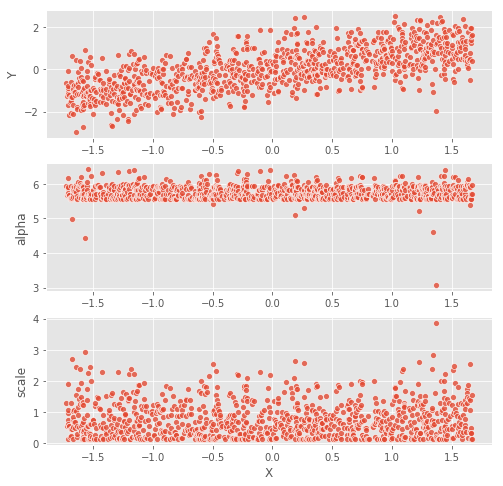

In [129]:
alpha_hat_indep = torch.exp(alpha_indep).data.numpy()
scale_hat_indep = torch.exp(scale_indep).data.numpy()
fig, ax = plt.subplots(3, 1, figsize=(8,8))
sns.scatterplot(x.data.numpy(), y.data.numpy(), ax=ax[0], alpha=0.8)
sns.scatterplot(x.data.numpy(), alpha_hat_indep, ax=ax[1], alpha=0.8)
sns.scatterplot(x.data.numpy(), scale_hat_indep, ax=ax[2], alpha=0.8)
ax[0].set_ylabel('Y')
ax[1].set_ylabel('alpha')
ax[2].set_ylabel('scale')
ax[2].set_xlabel('X')

In [130]:
# X_hat_indep = x.data.numpy()[alpha_hat_indep<2]
# noise_indep_hat = noise_indep[alpha_hat_indep<2]
# scale_hat_indep = scale_hat_indep[alpha_hat_indep<2]
# alpha_hat_indep = alpha_hat_indep[alpha_hat_indep<2]

# plt.figure(0, figsize=(4,4))
# sns.scatterplot(X_hat_indep, alpha_hat_indep)
# sns.scatterplot(X_hat_indep[noise_indep_hat], alpha_hat_indep[noise_indep_hat])

In [131]:
# Fit a linear regression using mean squared error.
alpha_hetero = nn.Parameter(torch.Tensor([0]*len(x_hetero)))
scale_hetero = nn.Parameter(torch.Tensor([0]*len(x_hetero)))
optimizer = torch.optim.Adam([scale_hetero, alpha_hetero]+list(params), lr = 1e-4) 
x = torch.Tensor(x_hetero)
y = torch.Tensor(y_hetero)
for epoch in range(20000): 
    
    # Hijacking the general loss to compute MSE.
    loss = torch.mean(robust_loss_pytorch.general.lossfun(
        y - x, alpha=torch.exp(alpha_hetero), scale=torch.exp(scale_hetero)))
    loss = loss + scale_hetero.mean() + dist.log_base_partition_function(torch.exp(alpha_hetero)).mean()

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 2000) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}'.format(epoch, loss.data))  

0   : loss=1.569302
2000: loss=1.408724
4000: loss=1.263404
6000: loss=1.089254
8000: loss=0.974849
10000: loss=0.906910
12000: loss=0.856145
14000: loss=0.816603
16000: loss=0.785122
18000: loss=0.759774


Text(0.5, 0, 'X')

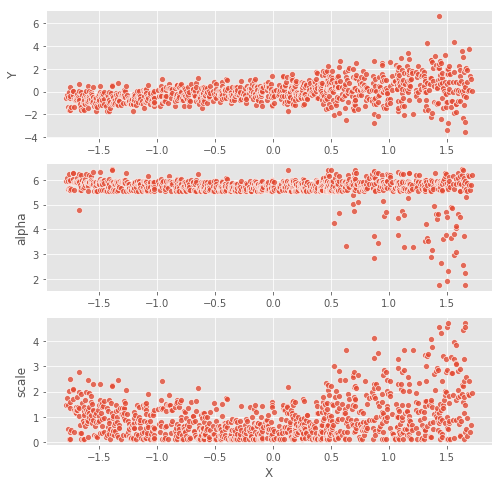

In [132]:
alpha_hat_hetero = torch.exp(alpha_hetero).data.numpy()
scale_hat_hetero = torch.exp(scale_hetero).data.numpy()
fig, ax = plt.subplots(3, 1, figsize=(8,8))
sns.scatterplot(x.data.numpy(), y.data.numpy(), ax=ax[0], alpha=0.8)
sns.scatterplot(x.data.numpy(), alpha_hat_hetero, ax=ax[1], alpha=0.8)
sns.scatterplot(x.data.numpy(), scale_hat_hetero, ax=ax[2], alpha=0.8)
ax[0].set_ylabel('Y')
ax[1].set_ylabel('alpha')
ax[2].set_ylabel('scale')
ax[2].set_xlabel('X')

In [133]:
# X_hat_hetero = x.data.numpy()[alpha_hat_hetero<2]
# noise_hetero_hat = noise_hetero[alpha_hat_hetero<2]
# scale_hat_hetero = scale_hat_hetero[alpha_hat_hetero<2]
# alpha_hat_hetero = alpha_hat_hetero[alpha_hat_hetero<2]

# plt.figure(0, figsize=(4,4))
# sns.scatterplot(X_hat_hetero, alpha_hat_hetero)
# sns.scatterplot(X_hat_hetero[noise_hetero_hat], alpha_hat_hetero[noise_hetero_hat])

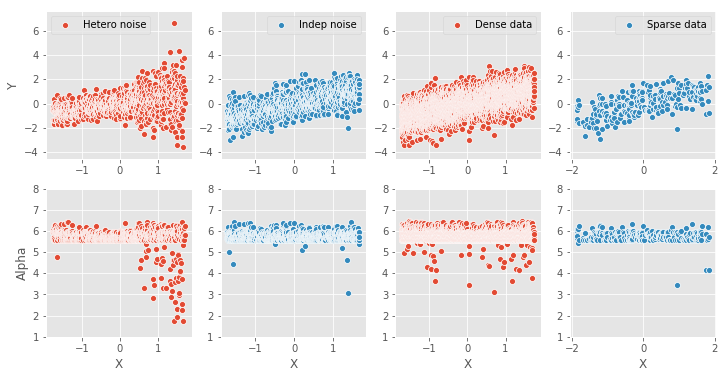

In [146]:
fig, ax = plt.subplots(2, 4, figsize=(12,6))
ax[0][0].set_ylabel('Y')
ax[0][0].set_ylim([min(y_hetero)-1, max(y_hetero)+1])
sns.scatterplot(x_hetero, y_hetero, label='Hetero noise', color=palette[0], ax=ax[0][0])
# sns.scatterplot(x_hetero[noise_hetero], y_hetero[noise_hetero], label='Outlier', color=palette[2], ax=ax[0][0])

ax[0][1].set_ylim([min(y_hetero)-1, max(y_hetero)+1])
sns.scatterplot(x_indep, y_indep, label='Indep noise', color=palette[1], ax=ax[0][1])
# sns.scatterplot(x_indep[noise_indep], y_indep[noise_indep], label='Outlier', color=palette[2], ax=ax[0][1])

ax[0][2].set_ylim([min(y_hetero)-1, max(y_hetero)+1])
sns.scatterplot(x_dense, y_dense, label='Dense data', color=palette[0], ax=ax[0][2])
# sns.scatterplot(x_dense[noise_dense], y_dense[noise_dense], label='Outlier', color=palette[2], ax=ax[0][2])

ax[0][3].set_ylim([min(y_hetero)-1, max(y_hetero)+1])
sns.scatterplot(x_sparse, y_sparse, label='Sparse data', color=palette[1], ax=ax[0][3])
# sns.scatterplot(x_sparse[noise_sparse], y_sparse[noise_sparse], label='Outlier', color=palette[2], ax=ax[0][3])

ax[1][0].set_ylabel('Alpha')
ax[1][0].set_xlabel('X')
ax[1][0].set_ylim([1, 8])
sns.scatterplot(x_hetero, alpha_hat_hetero, color=palette[0], ax=ax[1][0])
# sns.scatterplot(X_hat_hetero[noise_hetero_hat], alpha_hat_hetero[noise_hetero_hat], color=palette[2], ax=ax[1][0])

ax[1][1].set_ylim([1, 8])
ax[1][1].set_xlabel('X')
sns.scatterplot(x_indep, alpha_hat_indep, color=palette[1], ax=ax[1][1])
# sns.scatterplot(X_hat_indep[noise_indep_hat], alpha_hat_indep[noise_indep_hat], color=palette[2], ax=ax[1][1])

ax[1][2].set_ylim([1, 8])
ax[1][2].set_xlabel('X')
sns.scatterplot(x_dense, alpha_hat_dense, color=palette[0], ax=ax[1][2])
# sns.scatterplot(X_hat_dense[noise_dense_hat], alpha_hat_dense[noise_dense_hat], color=palette[2], ax=ax[1][2])

ax[1][3].set_ylim([1, 8])
ax[1][3].set_xlabel('X')
sns.scatterplot(x_sparse, alpha_hat_sparse, color=palette[1], ax=ax[1][3])
# sns.scatterplot(X_hat_sparse[noise_sparse_hat], alpha_hat_sparse[noise_sparse_hat], color=palette[2], ax=ax[1][3])
# 
# plt.savefig('non_param_alpha_wo_outlier.png')

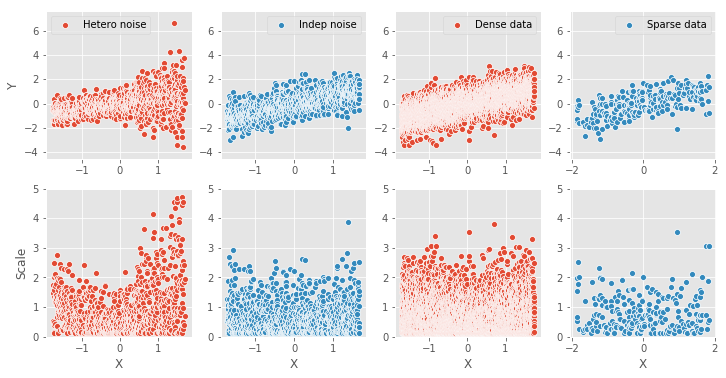

In [150]:
fig, ax = plt.subplots(2, 4, figsize=(12,6))
ax[0][0].set_ylabel('Y')
ax[0][0].set_ylim([min(y_hetero)-1, max(y_hetero)+1])
sns.scatterplot(x_hetero, y_hetero, label='Hetero noise', color=palette[0], ax=ax[0][0])
# sns.scatterplot(x_hetero[noise_hetero], y_hetero[noise_hetero], label='Outlier', color=palette[2], ax=ax[0][0])

ax[0][1].set_ylim([min(y_hetero)-1, max(y_hetero)+1])
sns.scatterplot(x_indep, y_indep, label='Indep noise', color=palette[1], ax=ax[0][1])
# sns.scatterplot(x_indep[noise_indep], y_indep[noise_indep], label='Outlier', color=palette[2], ax=ax[0][1])

ax[0][2].set_ylim([min(y_hetero)-1, max(y_hetero)+1])
sns.scatterplot(x_dense, y_dense, label='Dense data', color=palette[0], ax=ax[0][2])
# sns.scatterplot(x_dense[noise_dense], y_dense[noise_dense], label='Outlier', color=palette[2], ax=ax[0][2])

ax[0][3].set_ylim([min(y_hetero)-1, max(y_hetero)+1])
sns.scatterplot(x_sparse, y_sparse, label='Sparse data', color=palette[1], ax=ax[0][3])
# sns.scatterplot(x_sparse[noise_sparse], y_sparse[noise_sparse], label='Outlier', color=palette[2], ax=ax[0][3])

ax[1][0].set_ylabel('Scale')
ax[1][0].set_xlabel('X')
ax[1][0].set_ylim([0, 5])
sns.scatterplot(x_hetero, scale_hat_hetero, color=palette[0], ax=ax[1][0])
# sns.scatterplot(X_hat_hetero[noise_hetero_hat], scale_hat_hetero[noise_hetero_hat], color=palette[2], ax=ax[1][0])

# ax[1][1].set_ylim([1.2, 2.1])
ax[1][1].set_xlabel('X')
ax[1][1].set_ylim([0, 5])
sns.scatterplot(x_indep, scale_hat_indep, color=palette[1], ax=ax[1][1])
# sns.scatterplot(X_hat_indep[noise_indep_hat], scale_hat_indep[noise_indep_hat], color=palette[2], ax=ax[1][1])

# ax[1][2].set_ylim([1.2, 2.1])
ax[1][2].set_xlabel('X')
ax[1][2].set_ylim([0, 5])
sns.scatterplot(x_dense, scale_hat_dense, color=palette[0], ax=ax[1][2])
# sns.scatterplot(X_hat_dense[noise_dense_hat], scale_hat_dense[noise_dense_hat], color=palette[2], ax=ax[1][2])

# ax[1][3].set_ylim([1.2, 2.1])
ax[1][3].set_xlabel('X')
ax[1][3].set_ylim([0, 5])
sns.scatterplot(x_sparse, scale_hat_sparse, color=palette[1], ax=ax[1][3])
# sns.scatterplot(X_hat_sparse[noise_sparse_hat], scale_hat_sparse[noise_sparse_hat], color=palette[2], ax=ax[1][3])

# plt.savefig('non_param_scale_wo_outlier.png')